<a href="https://colab.research.google.com/github/DexterfreaK/XGboostUrban/blob/master/XGBoost_using_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
%pip install gdal

In [28]:
from osgeo import gdal
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [29]:
# All features in X imported and read as Array

popden = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/popden.tif")
popden = popden.ReadAsArray()
popden = np.where(popden < 0 , np.nan, popden)

# Add a new row of NaN values
new_row = np.empty((1, popden.shape[1]))
new_row[:] = np.nan
popden = np.append(popden, new_row, axis=0)

# Add a new column of NaN values
new_col = np.empty((popden.shape[0], 1))
new_col[:] = np.nan
popden = np.append(popden, new_col, axis=1)

In [30]:
# All features in X imported and read as Array

Slope = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/slope.tif")
Slope = Slope.ReadAsArray()
# Slope = Slope / np.max(Slope)
Slope = np.where(Slope < 0, np.nan, Slope)

In [31]:
Friction = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/friction.tif")
Friction = Friction.ReadAsArray()
Friction = np.where(Friction < 0 , np.nan, Friction)

In [32]:
Elevation = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/elevation.tif")
Elevation = Elevation.ReadAsArray()
Elevation = np.where(Elevation < 0 , np.nan, Elevation)

In [33]:
gdp2005 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/gdp2005.tif")
gdp2005 = gdp2005.ReadAsArray()
gdp2005 = np.where(gdp2005 < 0 , np.nan, gdp2005)

In [34]:
floods = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/floods.tif")
floods = floods.ReadAsArray()
floods = np.where(floods < 0 , np.nan, floods)

In [35]:
accessibility = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/accessibilty.tif")
accessibility = accessibility.ReadAsArray()
accessibility = np.where(accessibility < 0 , np.nan, accessibility)

In [36]:
Temp = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/Temp_2005.tif")
Temp = Temp.ReadAsArray()
new_row = np.empty((1, Temp.shape[1]))
new_row[:] = np.nan
Temp = np.append(Temp, new_row, axis=0)
Temp = np.where(Temp < 0 , np.nan, Temp)

In [37]:
builtup_05_06 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/05_06_builtup.tif")
builtup_05_06 = builtup_05_06.ReadAsArray()
builtup_05_06 = np.where(builtup_05_06 < 0 , np.nan, builtup_05_06)

In [38]:
builtup_11_12 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/11_12_builtup_some.tif")
builtup_11_12 = builtup_11_12.ReadAsArray()
builtup_11_12 = np.where(builtup_11_12 < 0 , np.nan, builtup_11_12)

In [39]:
builtup_15_16 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/15_16_builtup.tif")
builtup_15_16 = builtup_15_16.ReadAsArray()
builtup_15_16 = np.where(builtup_15_16 < 0 , np.nan, builtup_15_16)

Text(0.5, 1.0, 'Kamrup Temperature')

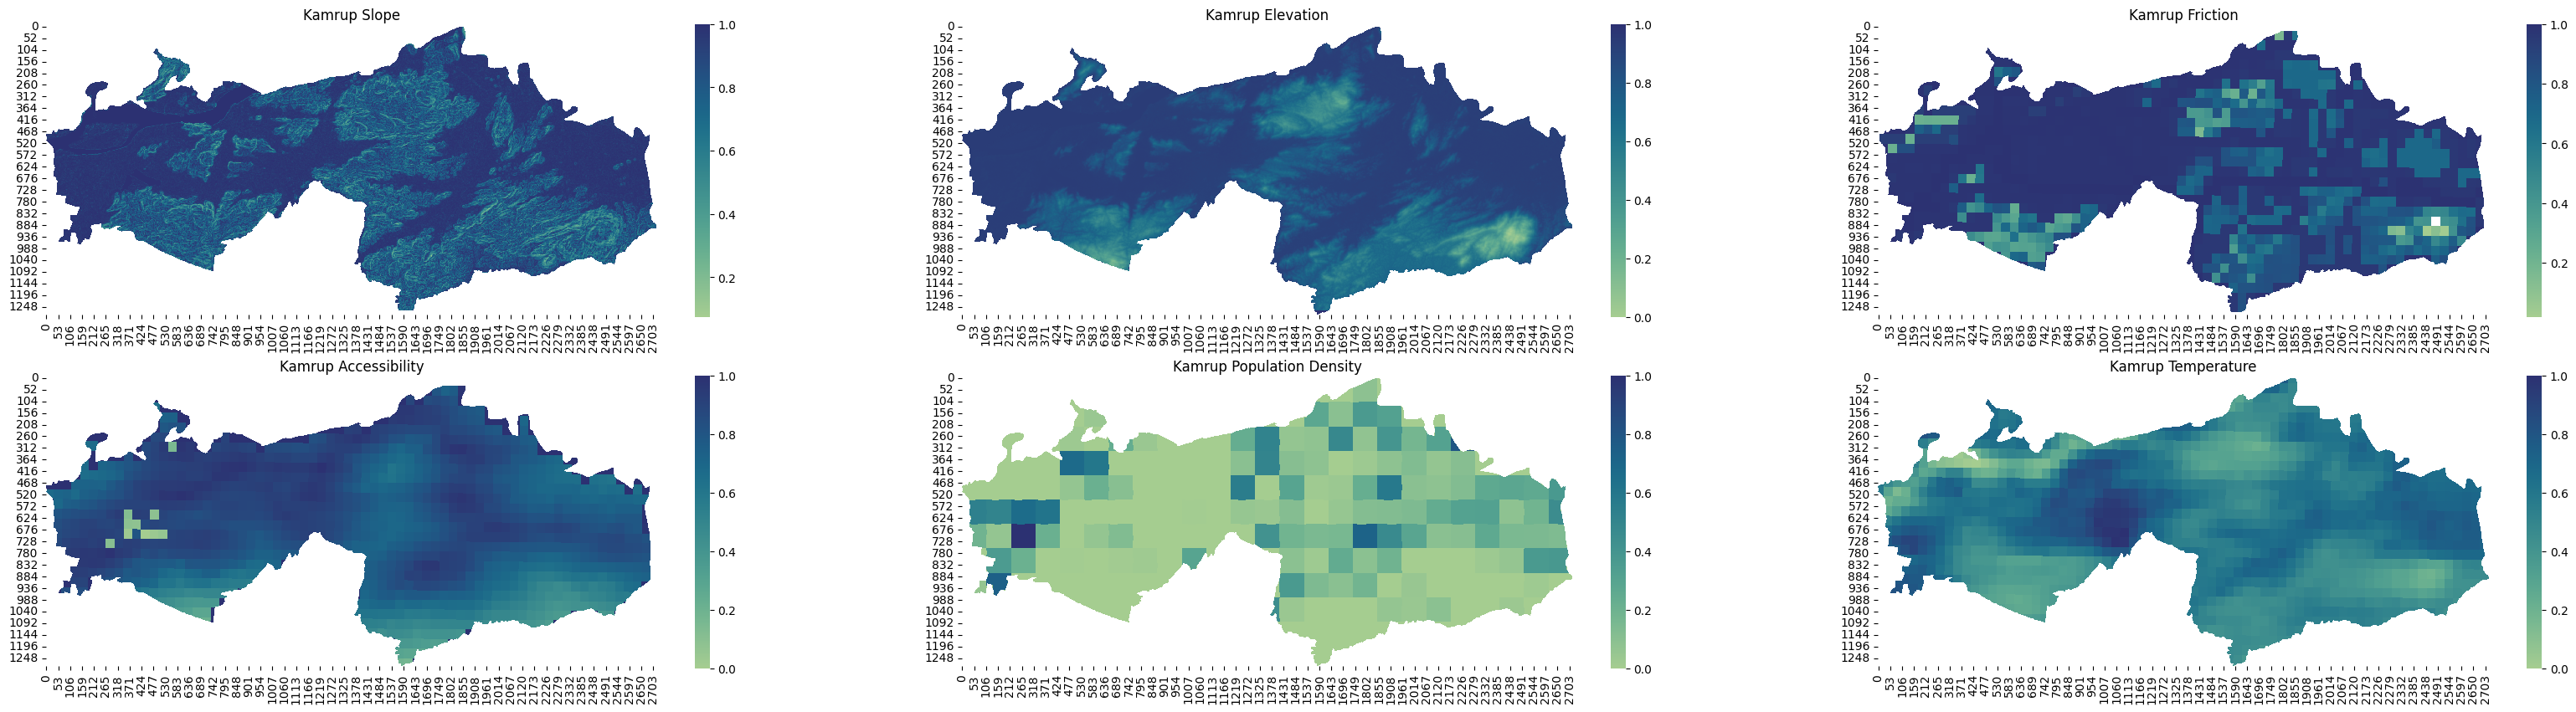

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, 3, figsize=(40, 10))

sns.heatmap(ax=axes[0, 0], data=Slope, square=True, cmap="crest").set_title('Kamrup Slope')
sns.heatmap(ax=axes[0, 1], data=Elevation, square=True, cmap="crest").set_title('Kamrup Elevation')
sns.heatmap(ax=axes[0, 2], data=Friction, square=True, cmap="crest").set_title('Kamrup Friction')
sns.heatmap(ax=axes[1, 0], data=accessibility, square=True, cmap="crest").set_title('Kamrup Accessibility')
sns.heatmap(ax=axes[1, 1], data=popden, square=True, cmap="crest").set_title('Kamrup Population Density')
sns.heatmap(ax=axes[1, 2], data=Temp, square=True, cmap="crest").set_title('Kamrup Temperature')

Text(0.5, 1.0, 'Kamrup Builtip 2015-2016')

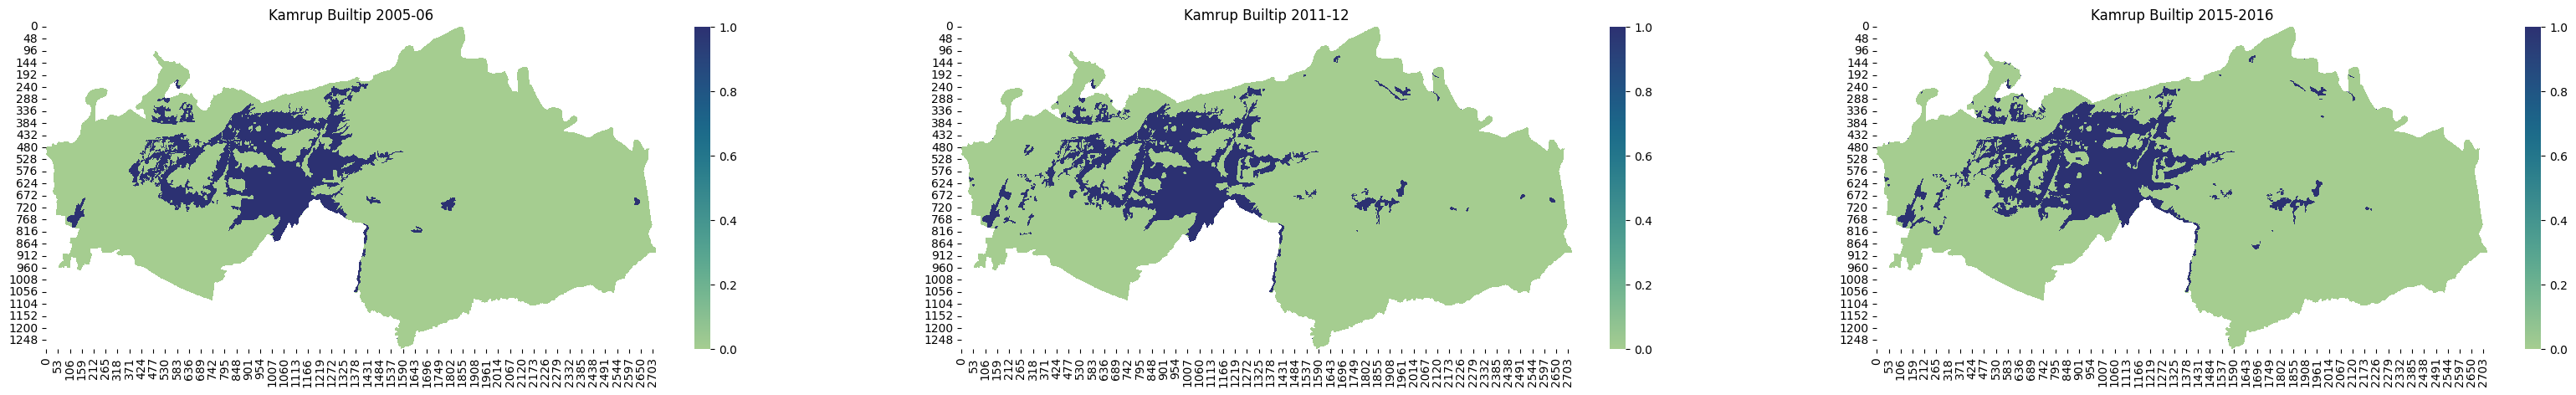

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(40, 5))
sns.heatmap(ax=axes[0], data=builtup_05_06, cmap="crest").set_title('Kamrup Builtip 2005-06')
sns.heatmap(ax=axes[1], data=builtup_11_12, cmap="crest").set_title('Kamrup Builtip 2011-12')
sns.heatmap(ax=axes[2], data=builtup_15_16, cmap="crest").set_title('Kamrup Builtip 2015-2016')

In [42]:
# Required Shape checking for All features
print(f'Slope - {Slope.shape}')
print(f'Elevation - {Elevation.shape}')
print(f'gdp2005 - {gdp2005.shape}')

print(f'popden - {popden.shape}')
print(f'Friction - {Friction.shape}')

print(f'floods - {floods.shape}')
print(f'accessibility - {accessibility.shape}')
print(f'builtup_05_06 - {builtup_05_06.shape}')
print(f'Temp - {Temp.shape}')

assert Slope.shape == popden.shape == Friction.shape == Elevation.shape == gdp2005.shape == floods.shape == accessibility.shape == builtup_05_06.shape==Temp.shape
(l,w) = Slope.shape

# Reshaping the image to be a 1d Array
Slope = np.reshape(Slope, (l*w,1))
popden = np.reshape(popden, (l*w,1))
Friction = np.reshape(Friction, (l*w,1))
Elevation = np.reshape(Elevation, (l*w,1))
floods = np.reshape(floods, (l*w,1))
accessibility = np.reshape(accessibility, (l*w,1))
builtup_05_06 = np.reshape(builtup_05_06, (l*w,1))
gdp2005 = np.reshape(gdp2005, (l*w,1))
Temp = np.reshape(Temp, (l*w,1))

Slope - (1283, 2719)
Elevation - (1283, 2719)
gdp2005 - (1283, 2719)
popden - (1283, 2719)
Friction - (1283, 2719)
floods - (1283, 2719)
accessibility - (1283, 2719)
builtup_05_06 - (1283, 2719)
Temp - (1283, 2719)


In [43]:
#Opening and Reading Y data
Y_data = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/Sub_11-05.tif")
Y_array = Y_data.ReadAsArray()
Y_array = np.where(Y_array < 0 , 0, Y_array)
print(Y_array.shape)
assert Y_array.shape == (l,w)

#Opening and Reshaping the data
Y_array = np.reshape(Y_array, (l*w,1))

(1283, 2719)


In [44]:
# Converting the array data to dataframe for both X and Y
df = pd.DataFrame({
    'Slope': Slope.flatten(),
    'Elevation': Elevation.flatten(),
    'PopDen': popden.flatten(),
    'Friction': Friction.flatten(),
    'Floods': floods.flatten(),
    'Accessibility': accessibility.flatten(),
    'Gdp2005': gdp2005.flatten(),
    'builtup': builtup_05_06.flatten(),
    'Temp':Temp.flatten(),
    'Y': Y_array.flatten(),
})


In [45]:
df.describe()

,Slope,Elevation,PopDen,Friction,Floods,Accessibility,Gdp2005,builtup,Temp,Y
count,1.937682e+06,1.939210e+06,1.937869e+06,1.935703e+06,1.939194e+06,1.935918e+06,1.939170e+06,1.939268e+06,1.939176e+06,3.488477e+06
mean,8.600398e-01,8.232493e-01,1.338998e-01,8.634150e-01,8.882453e-01,7.862569e-01,1.821177e-01,1.292622e-01,5.588484e-01,9.446816e-03
std,1.367591e-01,1.472543e-01,1.862207e-01,1.828166e-01,2.511740e-01,1.607000e-01,2.751711e-01,3.354900e-01,1.685054e-01,9.673457e-02
min,7.491708e-02,0.000000e+00,0.000000e+00,1.926445e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.715124e-01,7.523553e-01,0.000000e+00,7.655186e-01,1.000000e+00,7.155893e-01,1.772051e-02,0.000000e+00,4.451104e-01,0.000000e+00
50%,9.176646e-01,9.030955e-01,5.982101e-02,9.616657e-01,1.000000e+00,8.263523e-01,4.634973e-02,0.000000e+00,5.684696e-01,0.000000e+00
75%,9.706095e-01,9.259758e-01,1.912388e-01,9.809301e-01,1.000000e+00,9.018762e-01,1.996024e-01,0.000000e+00,6.780782e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [46]:
# dropping Y from X
X = df.drop('Y', axis=1)
Y = df['Y']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .80)

In [ ]:
params = {
            'objective':'binary:logistic',
            'max_depth': 6,
            'learning_rate': .3,
        }

xgb_model=XGBClassifier(**params)
model=xgb_model.fit(X_train,y_train)

Import some metrics and checking models' score

In [ ]:
from xgboost import plot_importance
plot_importance(xgb_model)

**Prediction of the Urbanised Map**

In [ ]:
y_pred = model.predict(X_test)
# y_pred = np.reshape(y_pred,(l,w)).astype(np.float32)

In [ ]:

from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision = {}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall = {}".format(recall_score(y_test, y_pred, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))


In [ ]:
y_pred = model.predict(X)
y_pred = np.reshape(y_pred,(l,w)).astype(np.float32)
plt.imshow(y_pred)

In [ ]:

Y_data = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/Sub_11-05.tif")
Y_array = Y_data.ReadAsArray()
Y_array = np.where(Y_array < 0 , 0, Y_array)
y_test = Y_array
plt.imshow(y_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision = {}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall = {}".format(recall_score(y_test, y_pred, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))


Converting predicted array to tiff image

In [ ]:
def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)

In [ ]:
write_geotiff('Predicted_subtracted_0.3_difference_with_Temp_binary_logistic.tiff',y_pred,Y_data)

Select parameters with `GridSearch`

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "n_estimators"     : [10, 20, 30]
     }

grid = GridSearchCV(clf, parameters, n_jobs=10, cv=3, verbose=3)

In [ ]:
grid.fit(X_train, y_train)